# Process KNMI catalog for Groningen

This code allows processing the latest KNMI catalog and plotting it in the Groningen field.

It is recommended to run this in the "Seismicity_model_env" virtual environment fo the GMG workflow.

In [9]:
#choose if you want the catalog inside the Groningen reservoir outline, or in the bounding box of the Reservoir
filter_outline = True #if this is true, the filtering will be done inside the reservoir outline

# Import Libraries

In [10]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from rijksdriehoek import rijksdriehoek

# Make sure you've manually downloaded the most recent .nc file from:
# https://browser.dataplatform.knmi.nl/index.html?dataset-name=aardbevingen_catalogus&dataset-version=1

In [11]:
# Read the .nc a nedCFD file using xarray library and put it into a pandas dataframe
ds = xr.open_dataset('SEISM_OPER_P___EQALL___L2.nc')
df = ds.to_dataframe()


In [12]:
# add a column with the decimal dates
#Define conversion to decimal years
def toYearFraction(date):
    from datetime import datetime as dt
    import time
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)
    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

df['DecDates'] = [toYearFraction(date) for date in  df.time]

In [13]:
#Using the rijksdriehoek library, convert lat, lon to dutch coordinates 

#conversion from Lat, Lon to RDX,RDY
rd_x_df,rd_y_df = [],[]
for lat,lon in zip(df.lat,df.lon):
    rd = rijksdriehoek.Rijksdriehoek()
    rd.from_wgs(lat,lon)
    rd_x_df.append(rd.rd_x)
    rd_y_df.append(rd.rd_y)
df['RDX'] = rd_x_df
df['RDY'] = rd_y_df

In [14]:
# Import the groningen outline, the faults and filter the catalog to be inside the reservoir
outline_file = '../ReservoirOutline.npy'
Outline = np.load(outline_file,allow_pickle=True)

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

df['point'] = df.apply(lambda row: Point(row['RDX'],row['RDY']),axis=1)
if filter_outline:
    polygon = Polygon([(x,y) for x,y in zip(Outline[:,-2],Outline[:,-1])])
else:
    polygon = Polygon([(np.min(Outline[:,-2]),np.min(Outline[:,-1])),(np.min(Outline[:,-2]),np.max(Outline[:,-1])),(np.max(Outline[:,-2]),np.max(Outline[:,-1])),(np.max(Outline[:,-2]),np.min(Outline[:,-1])),(np.min(Outline[:,-2]),np.min(Outline[:,-1]))])

polygon_0=polygon
df_gron = df[df['point'].apply(polygon.contains)].copy()

#Take events only with magnitude>1
df_gron = df_gron[df_gron.magnitude>1]

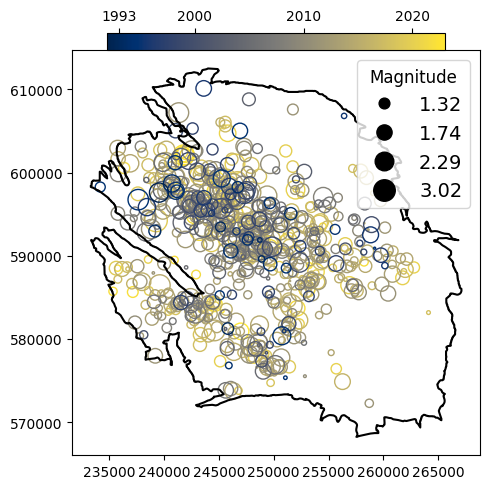

In [15]:
#Plot the catalog fileterd by before a date and in after that date

# Handle dates and sizes for the plot
dates = df_gron.DecDates.values
mag_scale = .5e3
sizes = np.log10(df_gron.magnitude.values)*mag_scale
cmap = plt.cm.cividis
norm = clrs.Normalize(vmin=np.min(dates), vmax=np.max(dates))

fig,ax = plt.subplots(1,figsize=(5,5))
sc =ax.scatter(df_gron.RDX,df_gron.RDY,s=sizes,edgecolors=cmap(norm(dates)),label='Full Catalog',fc="None")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#plot outline
ax.plot(Outline[:,-2],Outline[:,-1],c='k')
#handle the figure and colorbar
handles, labels = sc.legend_elements(prop="sizes", num=5) 
new_labels = ['{0:.2f}'.format(10**(int(''.join(char for char in string if char.isdigit()))/mag_scale)) for string in labels]
legend = ax.legend(handles, new_labels, loc="upper right", title="Magnitude",title_fontsize=12,prop={'size':14})

fig.colorbar(sm,ax=ax, location = 'top',orientation="horizontal",fraction=0.04,pad=0.001,ticks=[1993, 2000, 2010,2020])
plt.tight_layout()



In [16]:
df_gron

,iso_dataset,product,projection,id,time,lat,lon,depth,magnitude_type,magnitude,event_type,evaluation_mode,agency_id,location,link,DecDates,RDX,RDY,point
earthquakes,,,,,,,,,,,,,,,,,,,
0,b'',b'',b'',knmi2023baim,2023-01-15 09:49:09.699998720,53.37100,6.736000,3.0,MLn,1.846949,1,1,KNMI,Garsthuizen,http://rdsa.knmi.nl/fdsnws/event/1/query?inclu...,2023.039477,244774.118078,599133.771925,POINT (244774.11807805835 599133.7719251625)
1,b'',b'',b'',knmi2023aekc,2023-01-03 09:38:31.300000256,53.37100,6.736000,3.0,MLn,1.277893,1,1,KNMI,Garsthuizen,http://rdsa.knmi.nl/fdsnws/event/1/query?inclu...,2023.006580,244774.118078,599133.771925,POINT (244774.11807805835 599133.7719251625)
5,b'',b'',b'',knmi2022zhdw,2022-12-26 16:18:17.300000256,53.33200,6.729000,3.0,MLn,1.035627,1,1,KNMI,Loppersum,http://rdsa.knmi.nl/fdsnws/event/1/query?inclu...,2022.985423,244389.175703,594785.091628,POINT (244389.17570268936 594785.0916279644)
8,b'',b'',b'',knmi2022zajg,2022-12-22 23:04:47.299999232,53.20700,6.764000,3.0,MLn,1.898290,1,1,KNMI,Froombosch,http://rdsa.knmi.nl/fdsnws/event/1/query?inclu...,2022.975237,246986.664985,580919.452107,POINT (246986.66498456465 580919.452107298)
10,b'',b'',b'',knmi2022ylnl,2022-12-14 20:08:37.099999744,53.22900,6.740000,3.0,MLn,1.019789,1,1,KNMI,Woudbloem,http://rdsa.knmi.nl/fdsnws/event/1/query?inclu...,2022.952984,245337.316560,583337.141842,POINT (245337.31655975574 583337.1418416332)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,b'',b'',b'',knmi1993jkmv,1993-05-14 19:39:42.000000000,53.30533,6.793334,3.0,MLnq,1.050000,1,1,KNMI,Wirdum,http://rdsa.knmi.nl/fdsnws/event/1/query?inclu...,1993.366514,248732.673869,591899.112508,POINT (248732.67386862458 591899.1125076212)
5241,b'',b'',b'',knmi1993fyxa,1993-03-26 18:34:21.160000000,53.28483,6.795000,3.0,MLnq,1.100000,1,1,KNMI,Overschild,http://rdsa.knmi.nl/fdsnws/event/1/query?inclu...,1993.232257,248888.335892,589620.090019,POINT (248888.3358922365 589620.0900193787)
5254,b'',b'',b'',knmi1992yhii,1992-12-11 13:00:50.050000384,53.21017,6.746666,3.0,MLnq,1.370000,1,1,KNMI,Froombosch,http://rdsa.knmi.nl/fdsnws/event/1/query?inclu...,1992.944104,245821.978273,581250.198025,POINT (245821.97827309323 581250.1980254074)


In [17]:
first_date = f'{df_gron.time.min().year}-{df_gron.time.min().month:02d}'
last_date = f'{df_gron.time.max().year}-{df_gron.time.max().month:02d}'
if filter_outline:
    filename = 'KNMI_CAT_'+first_date+'to'+last_date+'_InsideReservoir.csv'
else:
    
df_gron.to_csv(filename)  